In this notebook,we want to 开发出来一种能够模拟Tip在热噪声作用下运动的代码，我们核心思想是利用Eular积分和Runge-Kutta 4th order积分来实现解方程，同时，由于我们的力F包含了热噪声，我们实际上在解随机微分方程.我们希望测试这两种方法的鲁棒性。

In [ ]:
import numpy as np

def harmosc(X, Q, F):
    """
    Damped harmonic oscillator with random driving force. Notice that 这一微分方程处理的时间是time*w0, 而位移则是x*w0,动量则是速度。
    Parameters:
        X[array]: displacement, velocity.
        Q[float]: quality factor.
        F[array]: force devided by mass and w0.
        x[float]: displacement time w0.
        p[float]: velocity.
        dotx[float]: change of displacement time w0.
        dotp[float]: change of velocity.
    Return:
        dotx, dotp[array]: change of displacement*w0 and velocity.
    """
    x, p = X
    dotx = p
    dotp = - x - (1 / Q) * p + F
    return np.array([dotx, dotp])

def solve(X0, dtau, Q, F):
    """
    Solve the damped harmonic oscillator equation using the Euler method.
    Parameters:
        x[float]: displacement time w0.
        p[float]: velocity.
        dtau[float]: time step*w0.
        Q[float]: quality factor.
        F[array]: force devided by mass and w0.
    Return:
        X[array]: displacement time w0, velocity.
    """
    X = np.zeros([np.shape(F)[0], 2])
    X[0] = X0
    for n, f in enumerate(F[:-1]):
        X[n+1, :] =  X[n, :] + dtau * harmosc(X[n], Q, f)
    return X



def solve_RK4(X0, dtau, Q, F):
    """
    Solve the damped harmonic oscillator equation using the Runge-Kutta 4th order method.
    """
    X = np.zeros([len(F)//4, 2])#F is the force time-series,对于欧拉积分，我们每个结果对应一个F，对于RK4，我们每个结果对应四个F，分别是(t,x),(t+dtau/2,x+dtau/2*k1/2),(t+dtau/2,x+dtau/2*k2/2),(t+dtau,x+dtau*k3)
    X[0] = X0
    for n, f in enumerate(F[:-1]):
        k1 = harmosc(X[n], Q, f)
        k2 = harmosc(X[n] + dtau * k1 / 2, Q, f)
        k3 = harmosc(X[n] + dtau * k2 / 2, Q, f)
        k4 = harmosc(X[n] + dtau * k3, Q, f)
        X[n+1, :] =  X[n, :] + dtau * (k1 + 2 * k2 + 2 * k3 + k4) / 6
    return X

In [2]:
F = [1,2,3,4,5]

for n, f in enumerate(F[:-1]):
    print(n, f)

0 1
1 2
2 3
3 4


# Test the Euler method

根据john的说法，high Q 的系统要求的的dtau要小，所以我们怀疑这两种方式的主要区别在于- (1 / Q) * p项的处理。所以我们直接假设F==0，观察damped harmaonic ossilator的运动轨迹是否正常



In [41]:
def real_answer(X0,dtau,Q,len):
    t = np.arange(0,len*dtau,dtau)
    x = X0[0]*np.exp(-t/Q/2)*np.cos(t*np.sqrt(-1/Q**2/4+1))+X0[1]*np.exp(-t/Q/2)*np.sin(t*np.sqrt(-1/Q**2/4+1))
    p = -X0[0]*np.exp(-t/Q/2)*np.sqrt(-1/Q**2/4+1)*np.sin(t*np.sqrt(-1/Q**2/4+1))+X0[1]*np.exp(-t/Q/2)*np.cos(t*np.sqrt(-1/Q**2/4+1))
    return np.array([x, p])


In [42]:

dtau = 0.05

F = np.zeros(1000)

Q_l = [1,2,5,7,10,20,50]

X0 = [10,0]

solved_X_l = []
real_X_l = []


for Q in Q_l:
    solved_X = solve(X0, dtau, Q, F)
    solved_X_l.append(solved_X)
    real_X = real_answer(X0,dtau,Q,np.shape(F)[0]-1)
    real_X_l.append(real_X)





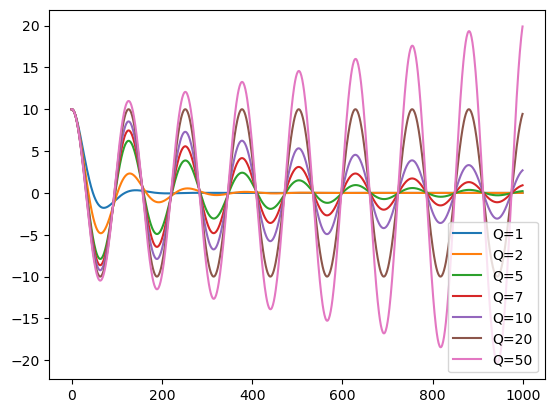

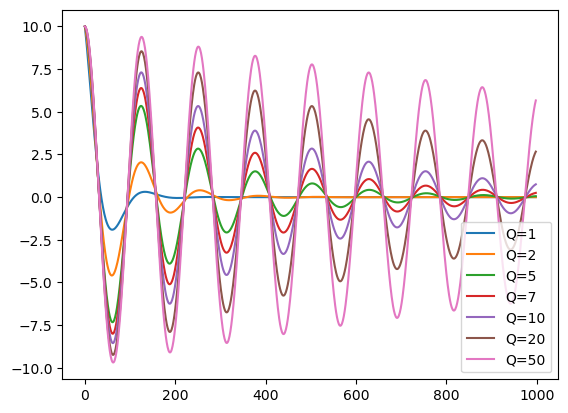

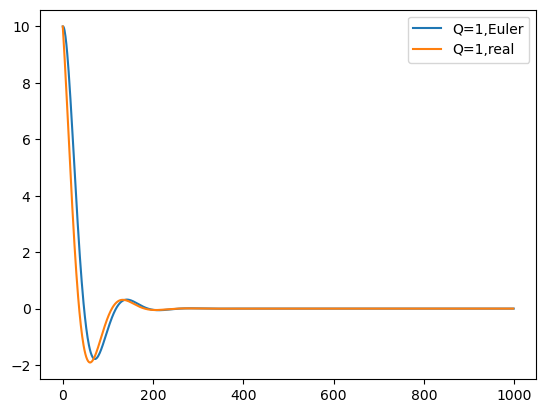

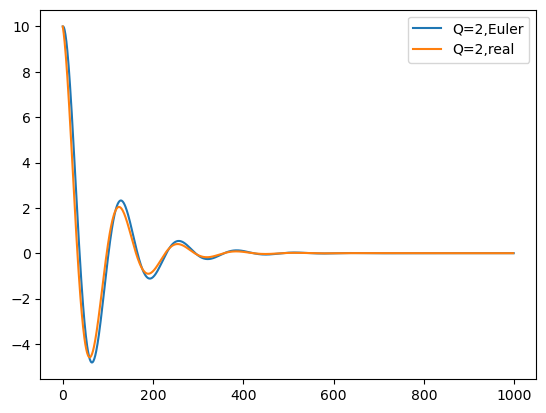

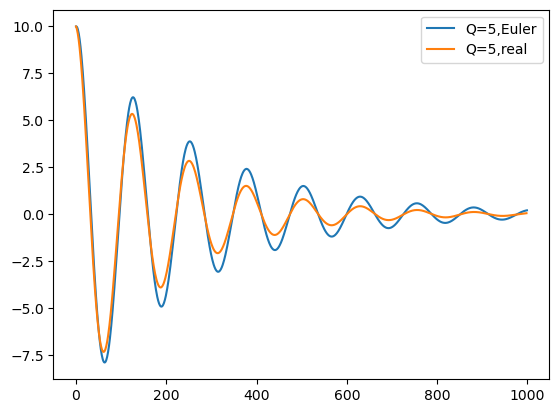

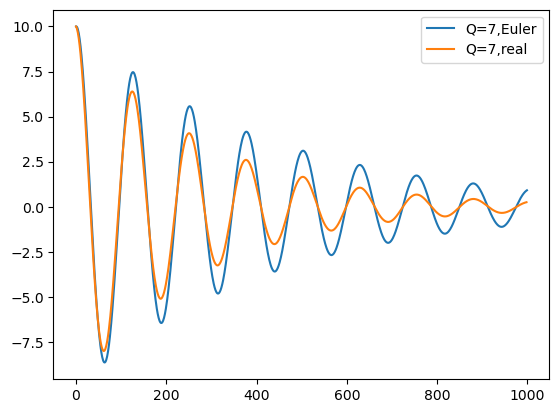

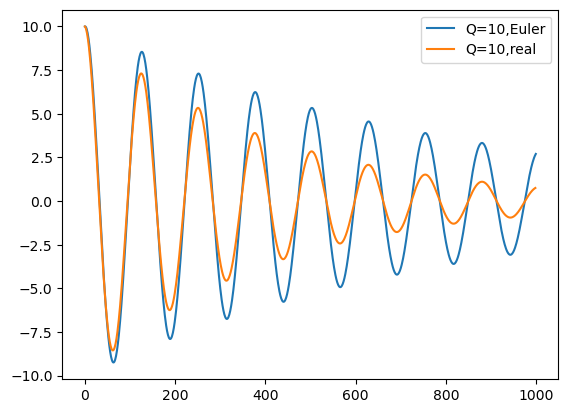

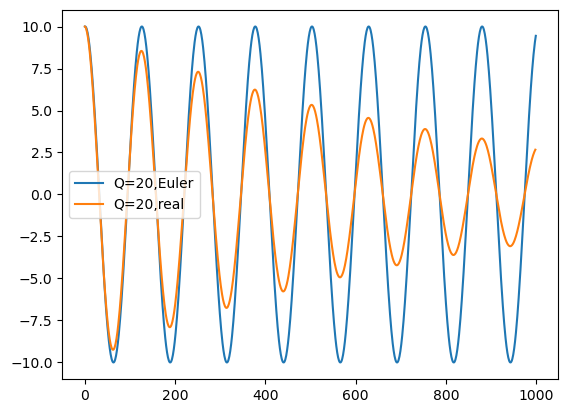

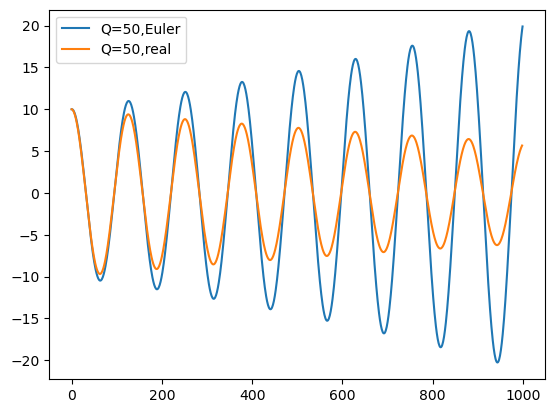

In [44]:
import matplotlib.pyplot as plt


for i,solved_X in enumerate(Q_l):
    plt.plot(solved_X_l[i][:,0],label=f'Q={Q_l[i]}')
plt.legend()
plt.show()

import matplotlib.pyplot as plt


for i,solved_X in enumerate(Q_l):
    plt.plot(real_X_l[i][0,:],label=f'Q={Q_l[i]}')
plt.legend()
plt.show()

for i,solved_X in enumerate(Q_l):
    plt.plot(solved_X_l[i][:,0],label=f'Q={Q_l[i]},Euler')
    plt.plot(real_X_l[i][0,:],label=f'Q={Q_l[i]},real')
    plt.legend()
    plt.show()

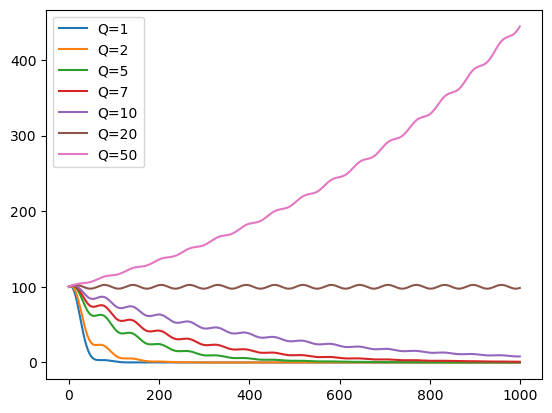

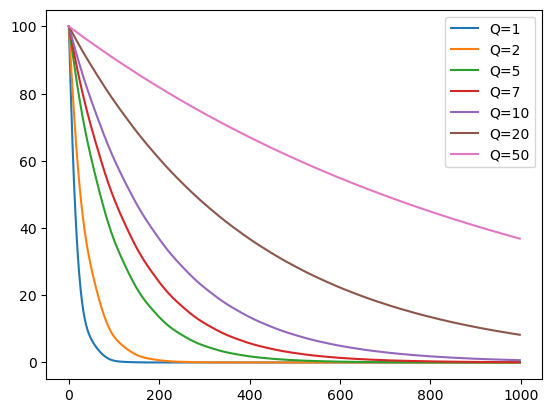

In [46]:


for i,solved_X in enumerate(Q_l):
    plt.plot(solved_X_l[i][:,0]**2+solved_X_l[i][:,1]**2,label=f'Q={Q_l[i]}')
plt.legend()
plt.show()



for i,solved_X in enumerate(Q_l):
    plt.plot(real_X_l[i][0,:]**2+real_X_l[i][1,:]**2,label=f'Q={Q_l[i]}')
plt.legend()
plt.show()

Yes, for high Q, the energy does not decay anymore.

In [73]:


def solve_RK4(X0, dtau, Q, F):
    """
    Solve the damped harmonic oscillator equation using the Runge-Kutta 4th order method.
    Parameters:
        x[float]: displacement time w0.
        p[float]: velocity.
        dtau[float]: time step*w0.
        Q[float]: quality factor.
        F[array[n,4]]: force devided by the mass.
    Return:
        X[array]: displacement time w0, velocity.
    """
    X = np.zeros([np.shape(F)[0], 2])#F is the force time-series,对于欧拉积分，我们每个结果对应一个F，对于RK4，我们每个结果对应四个F，分别是(t,x),(t+dtau/2,x+dtau/2*k1/2),(t+dtau/2,x+dtau/2*k2/2),(t+dtau,x+dtau*k3).
    X[0] = X0
    for n in range(np.shape(F)[0]-1):
        k1 = harmosc(X[n], Q, F[n][0])
        k2 = harmosc(X[n] + dtau * k1 / 2, Q, F[n][1])
        k3 = harmosc(X[n] + dtau * k2 / 2, Q, F[n][2])
        k4 = harmosc(X[n] + dtau * k3, Q, F[n][3])
        X[n+1, :] =  X[n, :] + dtau * (k1 + 2 * k2 + 2 * k3 + k4) / 6
    return X

In [76]:
F = np.zeros((1000,4))
F.shape

(1000, 4)

In [ ]:

dtau = 0.05

F = np.zeros(1000,4)

Q_l = [1,2,5,7,10,20,50]

X0 = [10,0]

solved_X_l = []
real_X_l = []


for Q in Q_l:
    solved_X = solve_RK4(X0, dtau, Q, F)
    solved_X_l.append(solved_X)
    real_X = real_answer(X0,dtau,Q,(np.shape(F)[0])//4-1)
    real_X_l.append(real_X)



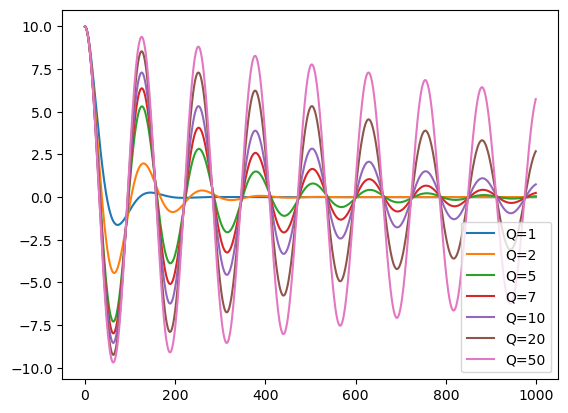

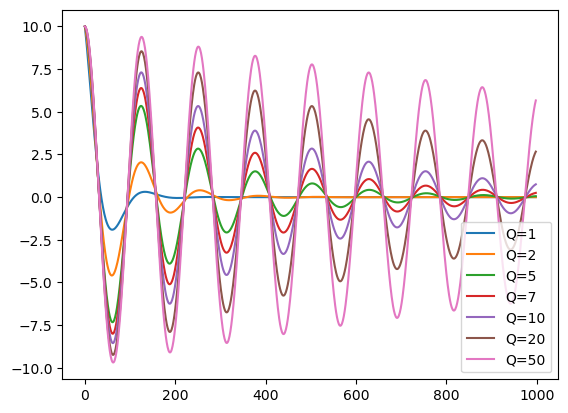

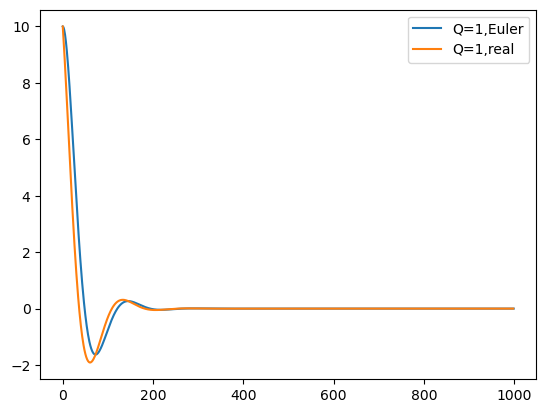

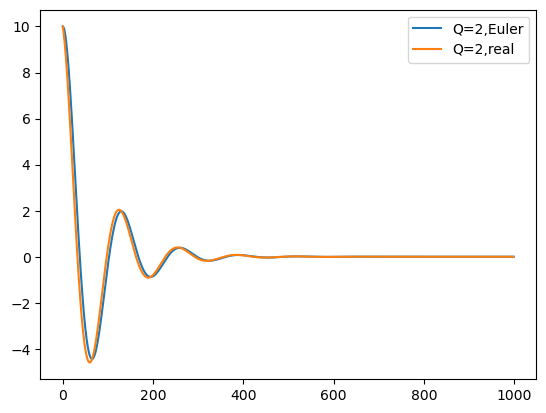

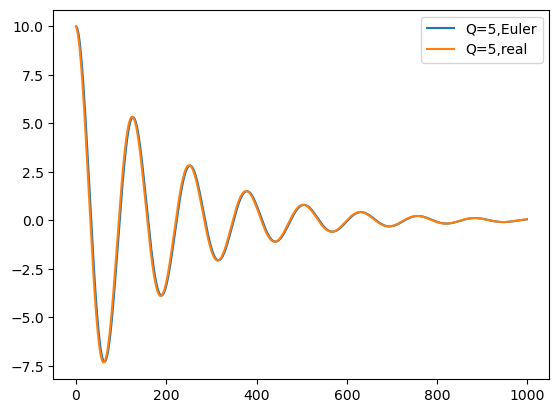

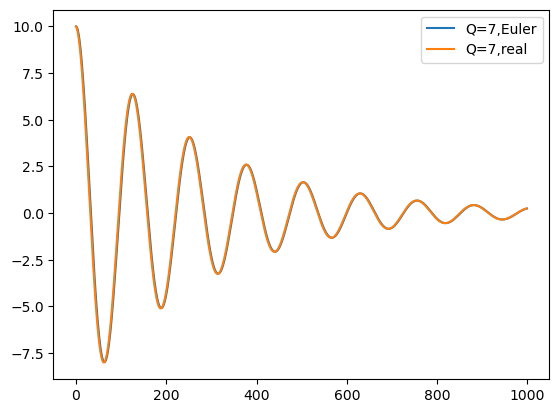

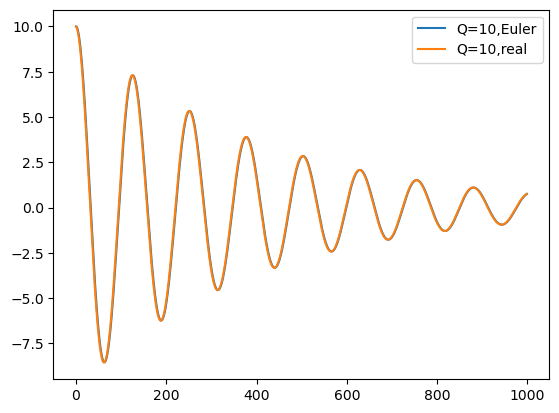

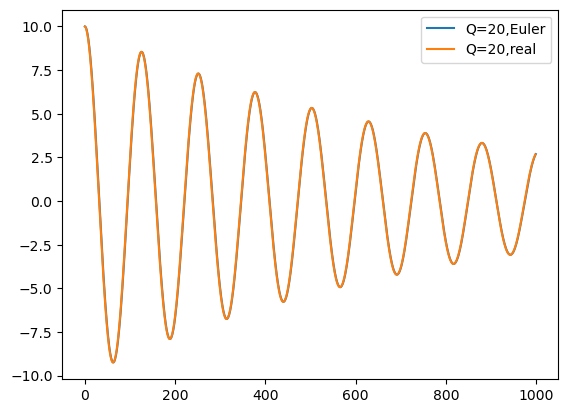

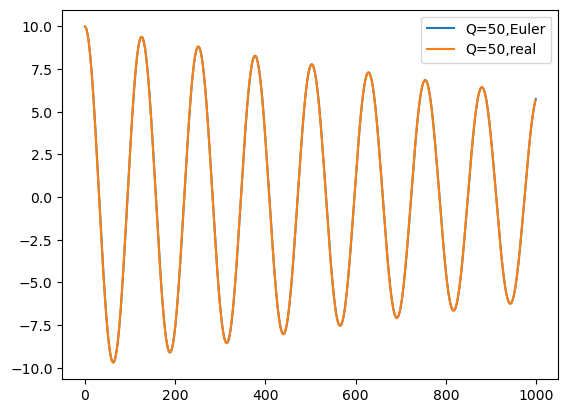

In [61]:
import matplotlib.pyplot as plt


for i,solved_X in enumerate(Q_l):
    plt.plot(solved_X_l[i][:,0],label=f'Q={Q_l[i]}')
plt.legend()
plt.show()

import matplotlib.pyplot as plt


for i,solved_X in enumerate(Q_l):
    plt.plot(real_X_l[i][0,:],label=f'Q={Q_l[i]}')
plt.legend()
plt.show()

for i,solved_X in enumerate(Q_l):
    plt.plot(solved_X_l[i][:,0],label=f'Q={Q_l[i]},Euler')
    plt.plot(real_X_l[i][0,:],label=f'Q={Q_l[i]},real')
    plt.legend()
    plt.show()

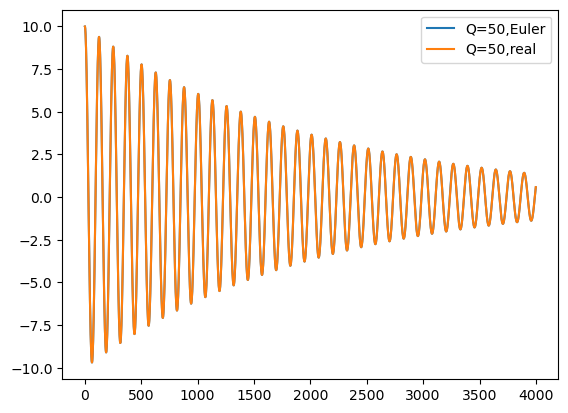

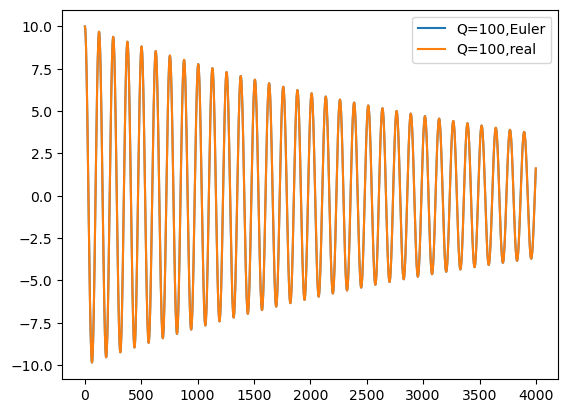

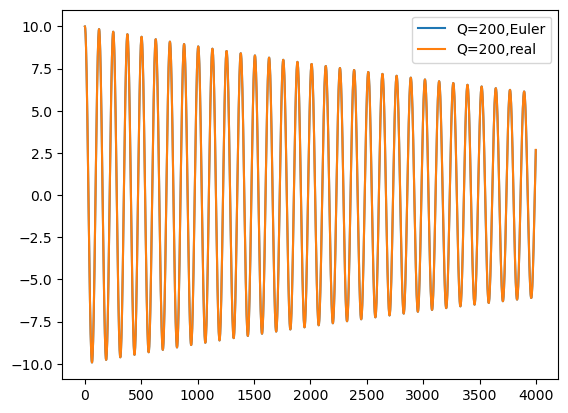

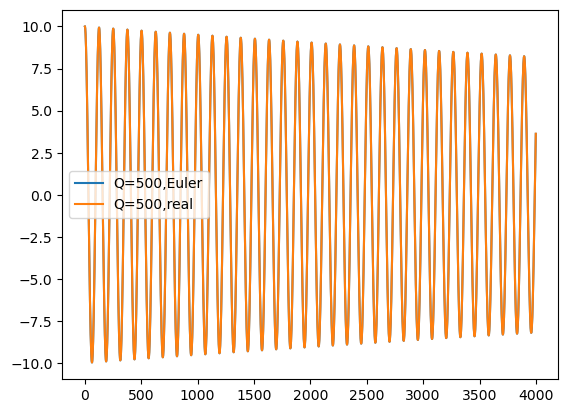

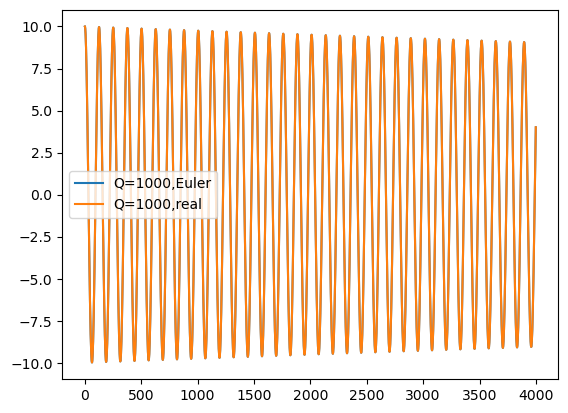

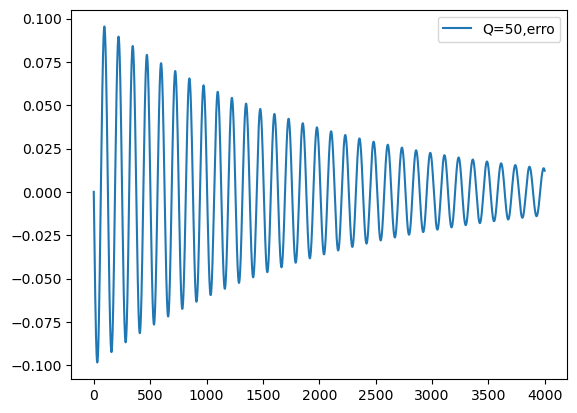

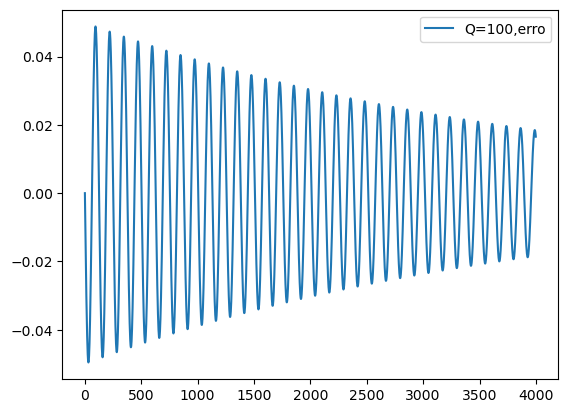

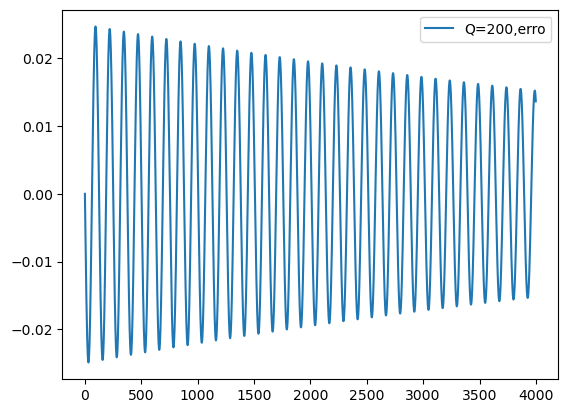

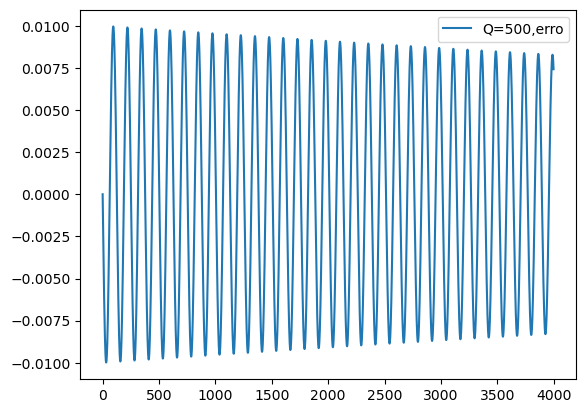

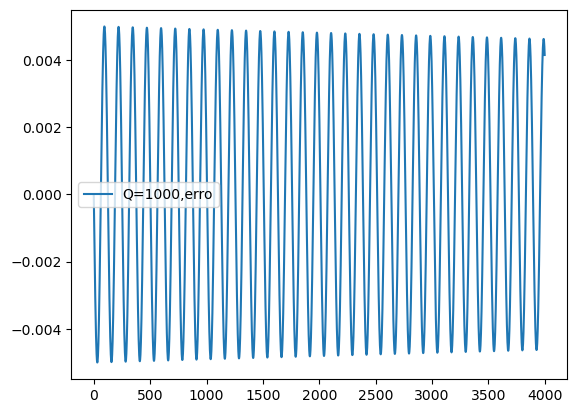

In [71]:

dtau = 0.05

F = np.zeros(16000)

Q_l = [50,100,200,500,1000]

X0 = [10,0]

solved_X_l = []
real_X_l = []


for Q in Q_l:
    solved_X = solve_RK4(X0, dtau, Q, F)
    solved_X_l.append(solved_X)
    real_X = real_answer(X0,dtau,Q,(np.shape(F)[0])//4)
    real_X_l.append(real_X)

for i,solved_X in enumerate(Q_l):
    plt.plot(solved_X_l[i][:,0],label=f'Q={Q_l[i]},Euler')
    plt.plot(real_X_l[i][0,:],label=f'Q={Q_l[i]},real')
    plt.legend()
    plt.show()

for i,solved_X in enumerate(Q_l):
    plt.plot(real_X_l[i][0,:]-solved_X_l[i][:,0],label=f'Q={Q_l[i]},erro')
    plt.legend()
    plt.show()

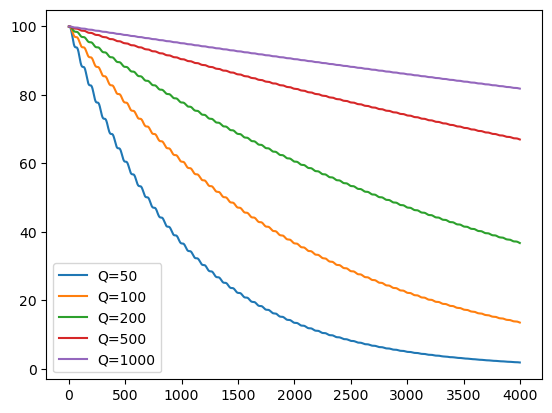

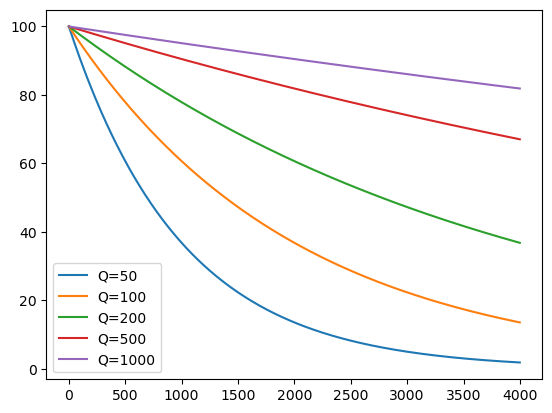

In [72]:
for i,solved_X in enumerate(Q_l):
    plt.plot(solved_X_l[i][:,0]**2+solved_X_l[i][:,1]**2,label=f'Q={Q_l[i]}')
plt.legend()
plt.show()



for i,solved_X in enumerate(Q_l):
    plt.plot(real_X_l[i][0,:]**2+real_X_l[i][1,:]**2,label=f'Q={Q_l[i]}')
plt.legend()
plt.show()

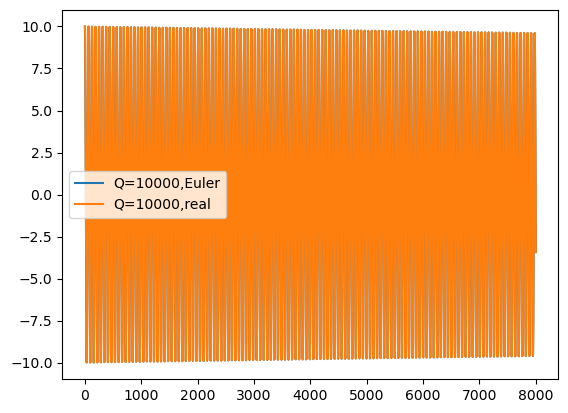

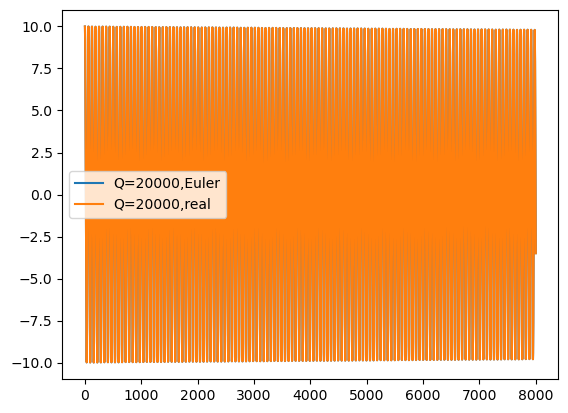

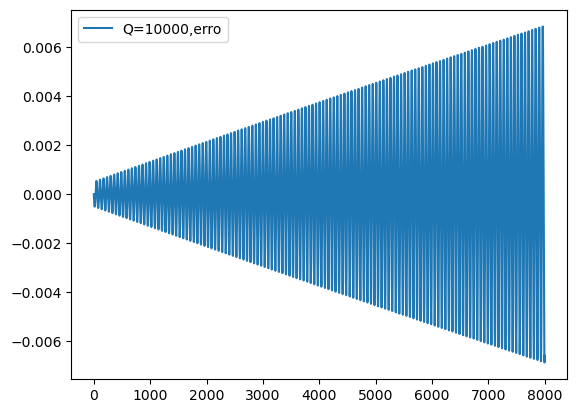

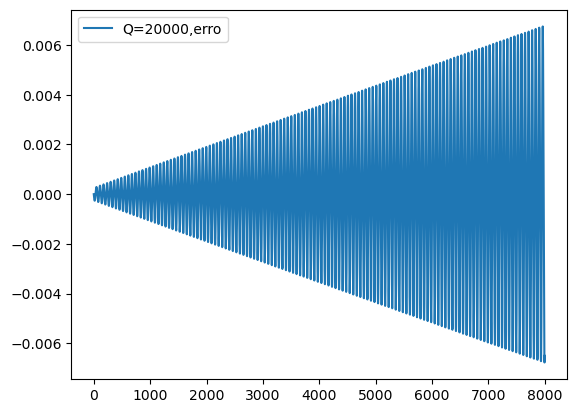

In [ ]:

dtau = 0.1

F = np.zeros((8000,4))

Q_l = [10000,20000]

X0 = [10,0]

solved_X_l = []
real_X_l = []


for Q in Q_l:
    solved_X = solve_RK4(X0, dtau, Q, F)
    solved_X_l.append(solved_X)
    real_X = real_answer(X0,dtau,Q,(np.shape(F)[0])//4)
    real_X_l.append(real_X)

for i,solved_X in enumerate(Q_l):
    plt.plot(solved_X_l[i][:,0],label=f'Q={Q_l[i]},Euler')
    plt.plot(real_X_l[i][0,:],label=f'Q={Q_l[i]},real')
    plt.legend()
    plt.show()

for i,solved_X in enumerate(Q_l):
    plt.plot(real_X_l[i][0,:]-solved_X_l[i][:,0],label=f'Q={Q_l[i]},erro')
    plt.legend()
    plt.show()

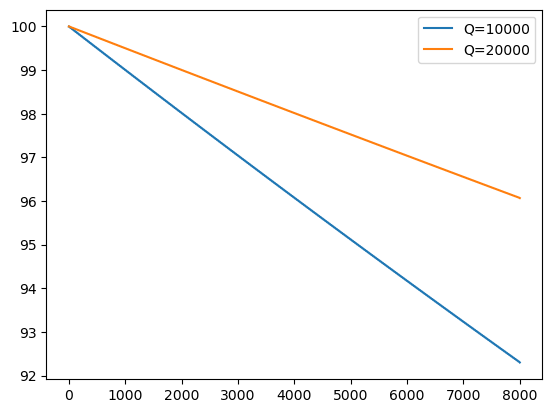

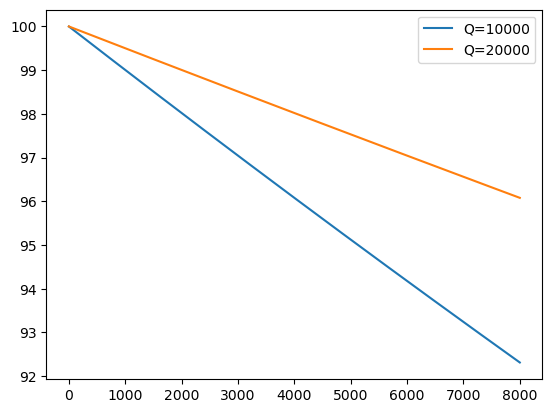

In [69]:
for i,solved_X in enumerate(Q_l):
    plt.plot(solved_X_l[i][:,0]**2+solved_X_l[i][:,1]**2,label=f'Q={Q_l[i]}')
plt.legend()
plt.show()



for i,solved_X in enumerate(Q_l):
    plt.plot(real_X_l[i][0,:]**2+real_X_l[i][1,:]**2,label=f'Q={Q_l[i]}')
plt.legend()
plt.show()

The Rk works pretty well,next step is to test the real parameters, and then test the noise. Also, is there other way to solve the random differential equation?

# Real parameters

In [78]:
750*2*np.pi*8000*10**-9

0.03769911184307752

In [86]:
w0 = 2*np.pi*8000
Q = 18000


dtau = 0.1

F1 = np.zeros((8000,4))

Q_l = [Q]

X0 = [750*w0*10**-9,0]

solved_X_l = []
real_X_l = []


for Q in Q_l:
    solved_X = solve_RK4(X0, dtau, Q, F)
    solved_X_l.append(solved_X)
    real_X = real_answer(X0,dtau,Q,np.shape(F)[0])
    real_X_l.append(real_X)




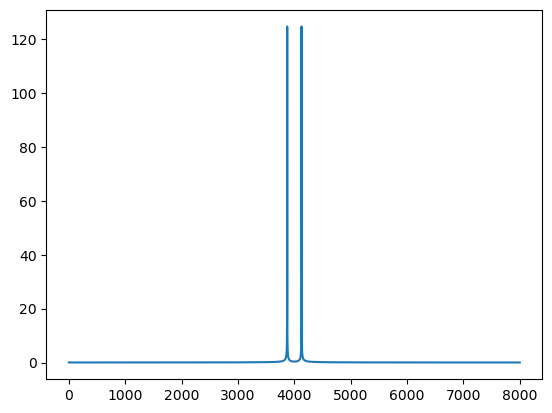

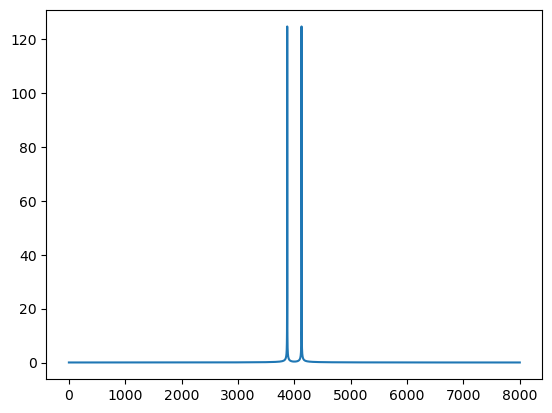

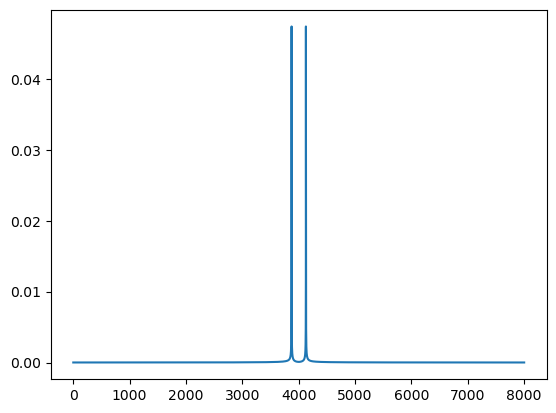

In [91]:
fft_X_Rk4 = np.fft.fft(solved_X_l[0][:,0])
fft_X_Rk4 = np.fft.fftshift(fft_X_Rk4)
plt.plot(np.abs(fft_X_Rk4))
plt.show()

fft_X_real = np.fft.fft(real_X_l[0][0,:])
fft_X_real = np.fft.fftshift(fft_X_real)
plt.plot(np.abs(fft_X_real))
plt.show()

plt.plot(np.abs(fft_X_real-fft_X_Rk4))
plt.show()

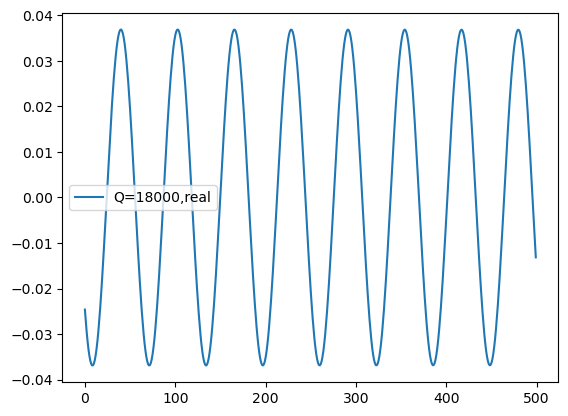

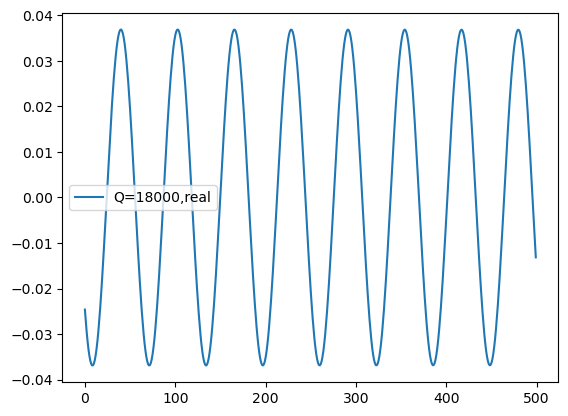

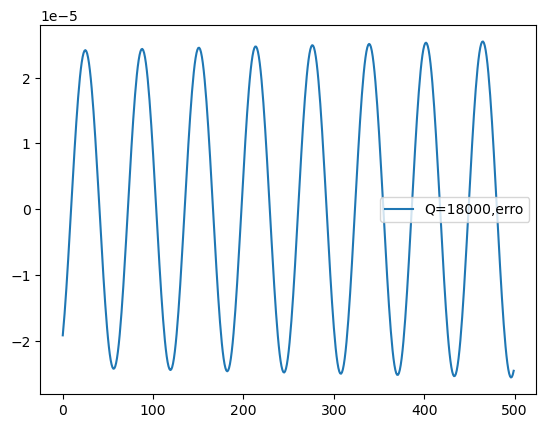

In [87]:
for i,solved_X in enumerate(Q_l):
    plt.plot(real_X_l[i][0,7500:],label=f'Q={Q_l[i]},real')
    plt.legend()
    plt.show()

for i,solved_X in enumerate(Q_l):
    plt.plot(real_X_l[i][0,7500:],label=f'Q={Q_l[i]},real')
    plt.legend()
    plt.show()

for i,solved_X in enumerate(Q_l):
    plt.plot(real_X_l[i][0,7500:]-solved_X_l[i][7500:,0],label=f'Q={Q_l[i]},erro')
    plt.legend()
    plt.show()

In [114]:
w0 = 2*np.pi*8000
Q = 18000


dtau = 0.05

F1 = np.zeros((int(Q*2*np.pi/dtau),4))

Q_l = [Q]

X0 = [750*w0*10**-9,0]

solved_X_l = []
real_X_l = []


for Q in Q_l:
    solved_X = solve_RK4(X0, dtau, Q, F)
    solved_X_l.append(solved_X)
    real_X = real_answer(X0,dtau,Q,np.shape(F)[0])
    real_X_l.append(real_X)

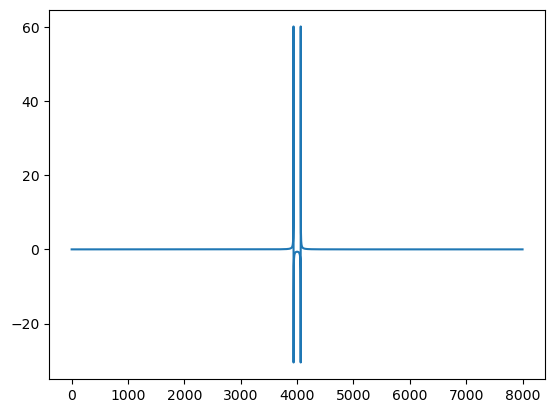

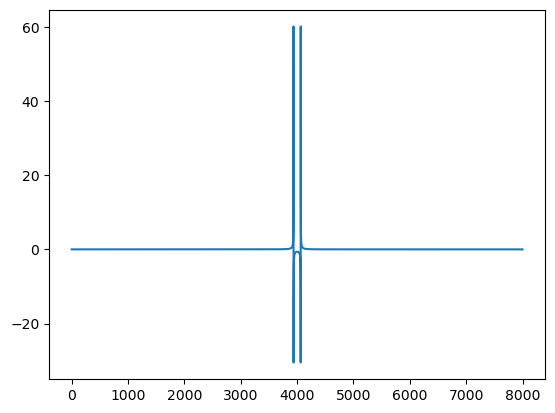

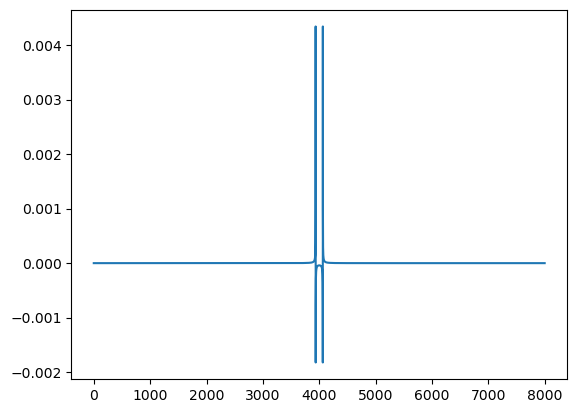

In [115]:
fft_X_Rk4 = np.fft.fft(solved_X_l[0][:,0])
fft_X_Rk4 = np.fft.fftshift(fft_X_Rk4)
plt.plot(np.real(fft_X_Rk4))
plt.show()

fft_X_real = np.fft.fft(real_X_l[0][0,:])
fft_X_real = np.fft.fftshift(fft_X_real)
plt.plot(np.real(fft_X_real))
plt.show()

plt.plot(np.real(fft_X_real-fft_X_Rk4))
plt.show()

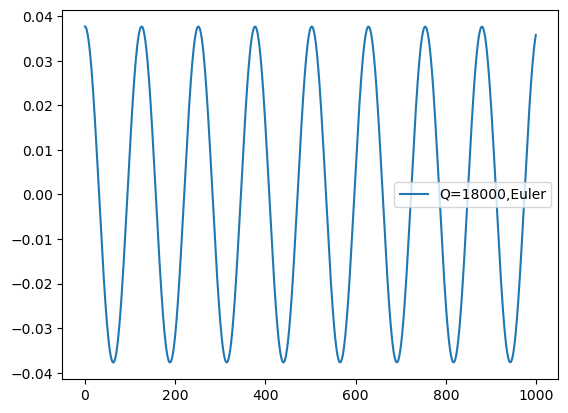

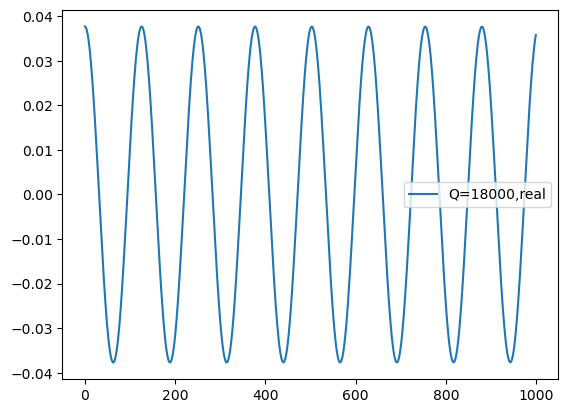

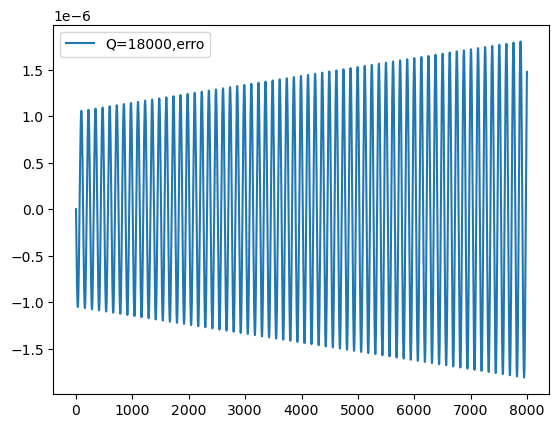

In [117]:
for i,solved_X in enumerate(Q_l):
    plt.plot(solved_X_l[i][:1000,0],label=f'Q={Q_l[i]},Euler')
    plt.legend()
    plt.show()

for i,solved_X in enumerate(Q_l):
    plt.plot(real_X_l[i][0,:1000],label=f'Q={Q_l[i]},real')
    plt.legend()
    plt.show()

for i,solved_X in enumerate(Q_l):
    plt.plot(real_X_l[i][0,:]-solved_X_l[i][:,0],label=f'Q={Q_l[i]},erro')
    plt.legend()
    plt.show()

The error is relative small, so this is the step to go.

#Try to add the noise to the system.

We assume F is Gaussian white noise. We know $<F(t)F(t+tau)> = D*delta(tau)$ and $<F> = 0$. According to the Wiener-Khinchin theorem, the one-sided power spectral density in the frequency domain is $S(f)_1 = D$. Assuming our step size is dt, the frequency resolution is 1/dt, so the variance of the noise within our window in the frequency domain is $2D/dt$. Therefore, the standard deviation of the force is actually \sqrt(D/dt). Meanwhile, we are actually concerned with F/m/w0, so the standard deviation is $\sqrt{2D/dt}/m/w0 = \sqrt{2D/m/w0/dt} =\sqrt{4k_BT/(Q m \omega_0dt)} = \sqrt{4k_BT\omega_0^2/(Q k \tau)} $. Thus, we can generate noise in the frequency domain and then perform an inverse Fourier transform to obtain the noise in the time domain.

In [ ]:
kb = 1.38*10**-23
T = 273
k = 2.7*10**-3
w0 = 2*np.pi*8000
Q = 18000
dtau = 0.1
std_F = np.sqrt(4*kb*T*w0**2/(Q*k*dtau))
# std_F = 1


Q_l = [Q]

X0 = [0,0]

l= []
for i in range(100):
    F = np.random.normal(0,std_F,size=(int(Q/dtau),4))
    solved_X = solve_RK4(X0, dtau, Q, F)
    l.append(solved_X)

In [253]:
NE = 0
for i in range(100):
    NE += (l[i][:,0]**2+l[i][:,1]**2)/2
NE = NE/100

NX = 0
for i in range(100):
    NX += (l[i][:,0]**2)
NX = NX/100

请注意，我们这里在能量前面用的是kbT/2，而不是推导里面的kbT，为什么？因为我们受迫振动近似是一个简谐运动，我们$<x^2>$和$<v^2>$分辨有时间系数sin^2(wt)和cos^2(wt)，所以加在一起并没有增大到kbT，而是kbT/2，在我峨嵋你的推导中，我们假定的期望是忽视了这种振动的，所以我们此处求得东西和我们关心得东西不是一个

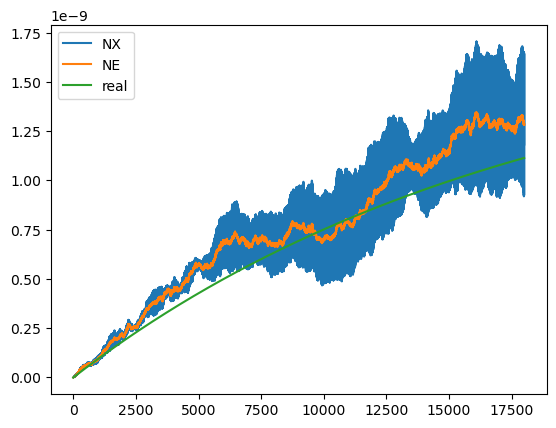

In [ ]:
x = np.arange(0,np.shape(solved_X)[0]*dtau,dtau)
plt.plot(x,NX,label='NX')
plt.plot(x,NE,label='NE')
y = kb*T/2/k*w0*w0*(1-np.exp(-x/Q))#the energy is k_B*T/2
plt.plot(x,y,label='real')
plt.legend()
plt.show()

In [286]:
solved_x_example.shape

(180000,)

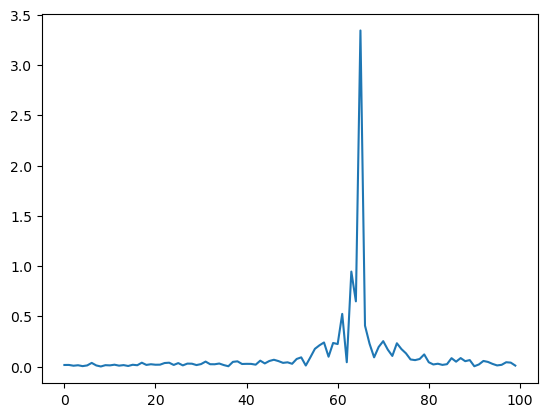

In [285]:
solved_x_example = l[0][:,0]
fft_solved_x_example = np.fft.fft(solved_x_example)
fft_solved_x_example = np.fft.fftshift(fft_solved_x_example)
plt.plot(np.abs(fft_solved_x_example[92800:92900]))
plt.show()


We noice one thing, the freq spectrum of the cantilever driven by the white noise is not uniform, it has a peak at resonance frequency

In [324]:
real_answer_example = real_answer(np.array([0.0001,0]),dtau,Q,solved_x_example.shape[0])

Signal_example = np.array(solved_x_example)+np.array(real_answer_example[0,:])



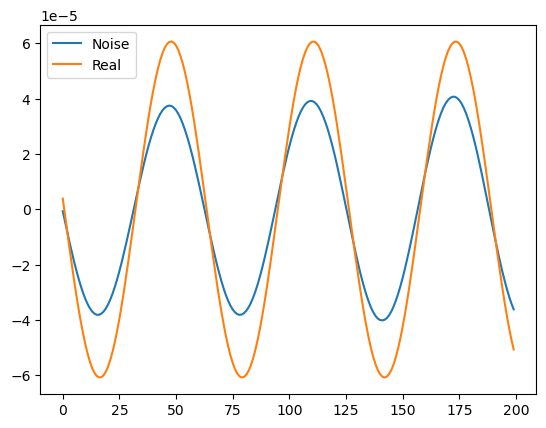

In [353]:
i = -600

plt.plot(solved_x_example[i:i+200],label='Noise')
# plt.plot(Signal_example[2000:3000],label='Signal')
plt.plot(real_answer_example[0,i:i+200],label='Real')
plt.legend()
plt.show()

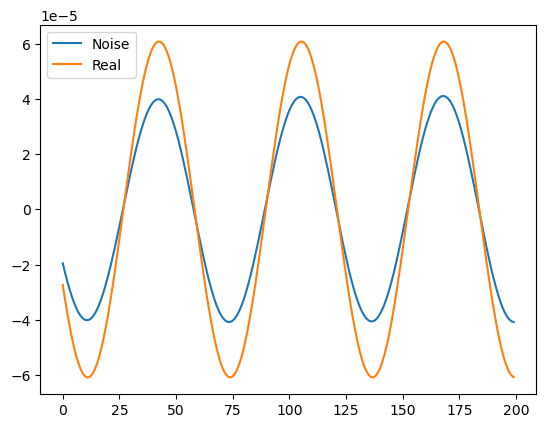

In [352]:
i = -1600

plt.plot(solved_x_example[i:i+200],label='Noise')
# plt.plot(Signal_example[2000:3000],label='Signal')
plt.plot(real_answer_example[0,i:i+200],label='Real')
plt.legend()
plt.show()

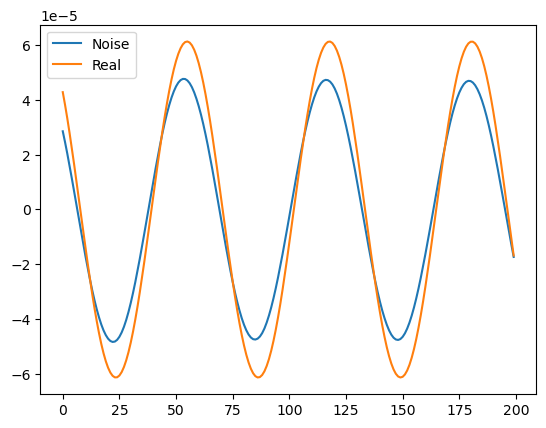

In [351]:
i = -4000

plt.plot(solved_x_example[i:i+200],label='Noise')
# plt.plot(Signal_example[2000:3000],label='Signal')
plt.plot(real_answer_example[0,i:i+200],label='Real')
plt.legend()
plt.show()

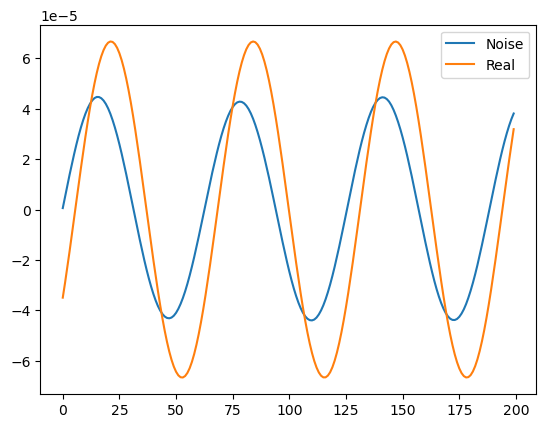

In [350]:
i = -34000

plt.plot(solved_x_example[i:i+200],label='Noise')
# plt.plot(Signal_example[2000:3000],label='Signal')
plt.plot(real_answer_example[0,i:i+200],label='Real')
plt.legend()
plt.show()
